In [16]:
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
SEED = 1000
IMG_SIZE = 256
BATCH_SIZE = 64

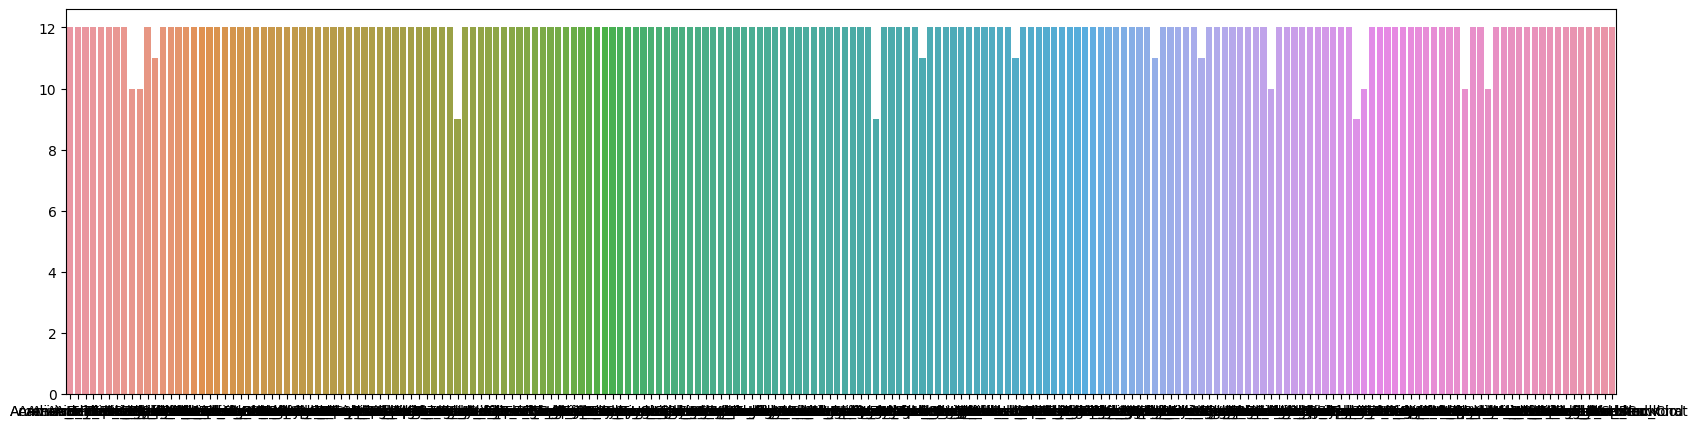

In [4]:
TRAIN_DIR = '/content/drive/MyDrive/Test'
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
  files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
  class_names.append(f)
  class_count.append(len(files))
  train_examples += len(files)
plt.figure(figsize=(20,5))
sns.barplot(x=class_names, y=class_count)
plt.savefig('foo.png',dpi=1000)
plt.show()

In [5]:
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    seed=SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    seed=SEED
)


Found 1777 images belonging to 200 classes.
Found 597 images belonging to 200 classes.


In [6]:
# Define your custom model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy']
)

In [8]:
cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_learning_rate=0.00001, verbose=2)
custom_model = model.fit(
    train_batch,
    epochs=20,
    steps_per_epoch=1777 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps=597 // BATCH_SIZE,
    callbacks=[cb, reduce_lr]
)

Epoch 1/20
27/27 [==============================] - 988s 37s/step - loss: 5.3040 - accuracy: 0.0023 - val_loss: 5.2998 - val_accuracy: 0.0035 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - 332s 12s/step - loss: 5.3003 - accuracy: 0.0035 - val_loss: 5.2978 - val_accuracy: 0.0017 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - 338s 13s/step - loss: 5.2971 - accuracy: 0.0041 - val_loss: 5.2976 - val_accuracy: 0.0087 - lr: 0.0010
Epoch 4/20
27/27 [==============================] - 329s 12s/step - loss: 5.2964 - accuracy: 0.0064 - val_loss: 5.2971 - val_accuracy: 0.0052 - lr: 0.0010
Epoch 5/20
27/27 [==============================] - 339s 13s/step - loss: 5.2962 - accuracy: 0.0047 - val_loss: 5.2950 - val_accuracy: 0.0069 - lr: 0.0010
Epoch 6/20
27/27 [==============================] - 331s 12s/step - loss: 5.2958 - accuracy: 0.0070 - val_loss: 5.2962 - val_accuracy: 0.0035 - lr: 0.0010
Epoch 7/20
27/27 [==============================] - ETA: 0s - loss: 5.

In [10]:
model.save("/content/drive/MyDrive/custom_model.h5")

In [11]:
print(custom_model.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


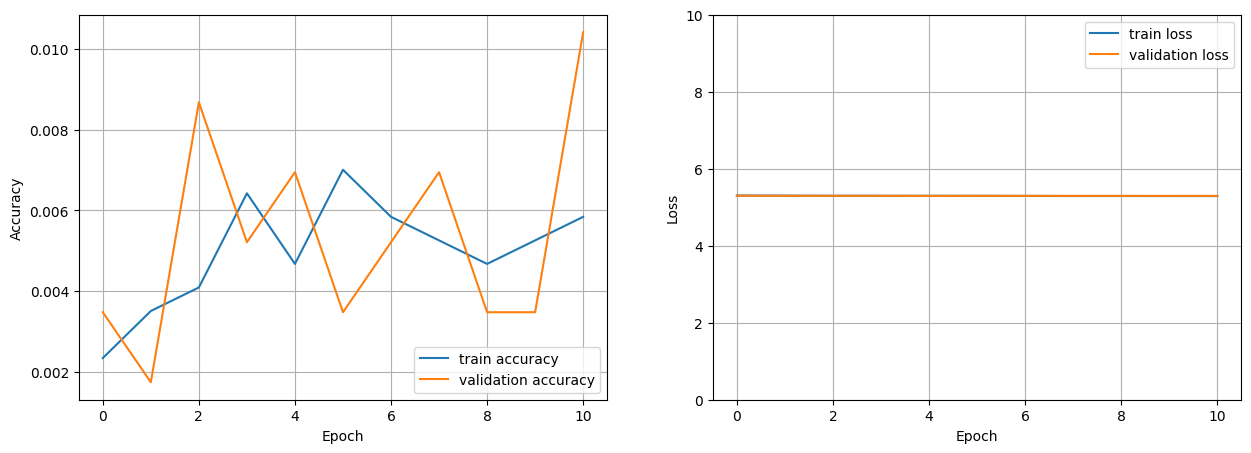

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(custom_model.history['accuracy'], label='train accuracy')
plt.plot(custom_model.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(custom_model.history['loss'], label='train loss')
plt.plot(custom_model.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0, 10])
plt.legend(loc='upper right')
plt.savefig("custom_model.pdf", dpi=300)
plt.show()

In [13]:
model = tf.keras.models.load_model('/content/drive/MyDrive/custom_model.h5')

10/10 [==============================] - 36s 3s/step


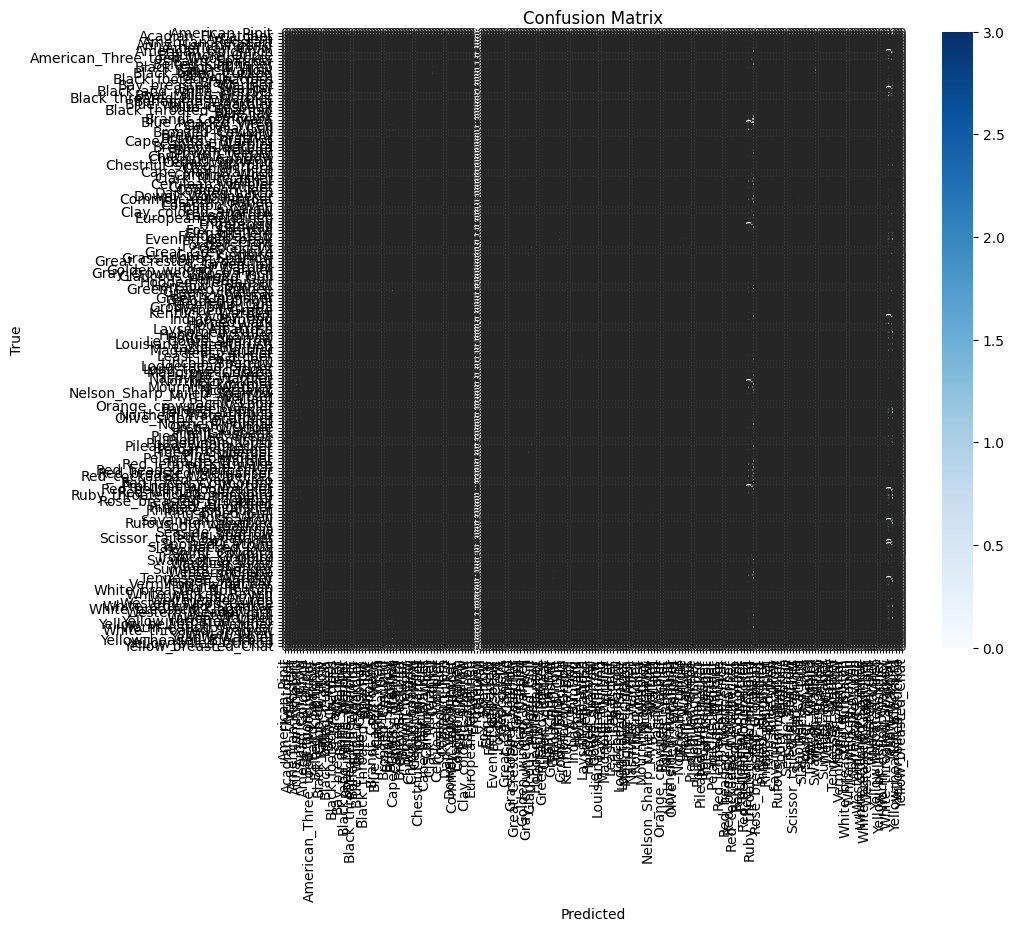

In [17]:
# Predict on validation data
y_pred = model.predict(valid_batch)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = valid_batch.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

In [20]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image

image_path = '/content/drive/MyDrive/Test/American_Pipit/American_Pipit_0001_100225.jpg'
preprocessed_image = preprocess_image(image_path)

In [21]:
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

predictions = model.predict(preprocessed_image)

1/1 [==============================] - 0s 150ms/step


In [22]:
class_indices = train_batch.class_indices
class_mapping = {v: k for k, v in class_indices.items()}

In [23]:
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_mapping[predicted_class_index]
print("Predicted class:", predicted_class_name)

Predicted class: Evening_Grosbeak
